<img src= 'http://www.bigbang-datascience.com/wp-content/uploads/2017/09/cropped-Logo-01.jpg' width=500/>

<h2 style="margin-bottom: 18px">Index</h2>

* AirBnb datasets
* Confusion matrix
* Resampling
* Random under-sampling
* Random over-sampling
* Python imbalanced-learn module
* Random under-sampling and over-sampling with imbalanced-learn
* Under-sampling: Tomek links
* Under-sampling: Cluster Centroids
* Over-sampling: SMOTE
* Over-sampling followed by under-sampling
* Recommended reading

<h2 id="t1" style="margin-bottom: 18px">Imbalanced datasets</h2>

In this kernel we will know some techniques to handle highly unbalanced datasets, with a focus on resampling. The Porto Seguro's Safe Driver Prediction competition, used in this kernel, is a classic problem of unbalanced classes, since insurance claims can be considered unusual cases when considering all clients. Other classic examples of unbalanced classes are the detection of financial fraud and attacks on computer networks.

Let's see how unbalanced the dataset is:

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set()  #  Will import Seaborn functionalities
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')



# Import Classifiers packages

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import tree

from catboost import CatBoostClassifier  # Added 
from sklearn.linear_model import SGDClassifier  # Added 

In [2]:
airbnbDF = pd.read_csv('airbnb_final.csv')

In [3]:
airbnbDF.shape

(10809, 19)

In [4]:
airbnbDF.head()

,id,latitude,longitude,neighbourhood_cleansed,price,availability_365,number_of_reviews_ltm,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,Zip,Median household income in 1999,Restaurant_Count,Attraction_Count
0,2265,30.27752,-97.71377,78702,$200.00,37,2,Entire residential home,Entire home/apt,2 baths,2.0,2.0,"[""Free street parking"", ""Free dryer \u2013 In ...",7,180,78702.0,23348.0,10.0,1.0
1,5245,30.27614,-97.71320,78702,$114.00,58,0,Private room in residential home,Private room,1 private bath,1.0,2.0,"[""Free street parking"", ""Air conditioning"", ""L...",30,90,78702.0,23348.0,8.0,1.0
2,5456,30.26057,-97.73441,78702,$104.00,324,35,Entire guesthouse,Entire home/apt,1 bath,1.0,2.0,"[""Free street parking"", ""Patio or balcony"", ""E...",2,90,78702.0,23348.0,13.0,6.0
3,5769,30.45697,-97.78422,78729,$39.00,0,7,Private room in residential home,Private room,1 shared bath,1.0,1.0,"[""Hair dryer"", ""First aid kit"", ""Dishes and si...",1,14,78729.0,59497.0,6.0,1.0
4,6413,30.24885,-97.73587,78704,$109.00,0,5,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,"[""Free street parking"", ""Patio or balcony"", ""A...",3,365,78704.0,35733.0,4.0,3.0


In [5]:
# Column names may be accessed (and changed) using the `.columns` attribute as below
print("Old Column Names:\n", airbnbDF.columns) 

Old Column Names:
 Index(['id', 'latitude', 'longitude', 'neighbourhood_cleansed', 'price',
       'availability_365', 'number_of_reviews_ltm', 'property_type',
       'room_type', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'minimum_nights', 'maximum_nights', 'Zip',
       'Median household income in 1999', 'Restaurant_Count',
       'Attraction_Count'],
      dtype='object')


In [6]:
# Stripping out spaces from ends of names, and replacing internal spaces with "_", why? it is easy to handle and progr
print("\nStripping spaces from ends of column names; replacing internal spaces with '_'\n")
airbnbDF.columns = [col.strip().replace(' ', '_').lower() for col in airbnbDF.columns]

# Print edited column names
print("\nNew Column Names:\n", airbnbDF.columns)


Stripping spaces from ends of column names; replacing internal spaces with '_'


New Column Names:
 Index(['id', 'latitude', 'longitude', 'neighbourhood_cleansed', 'price',
       'availability_365', 'number_of_reviews_ltm', 'property_type',
       'room_type', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'minimum_nights', 'maximum_nights', 'zip',
       'median_household_income_in_1999', 'restaurant_count',
       'attraction_count'],
      dtype='object')


In [7]:
#! pip install bamboolib

### A Few Useful Functions

With data in hand, it is time to look at a few functions which will be critical to your succes in understanding and completeing this assignment. All of the functions come from the "`numpy`" package. "`Numpy`" will be more completely introduced in week 8.  

The functions are:  

- `np.mean` - For calculating a mean
- `np.std` - For calculating standard deviation
- `np.var` - For calculating variance
- `np.ptp` - For calculating range (ptp stands for "point to point")
- `np.sqrt` - For taking the square root of a number (instead of x \*\* .5)
- `np.min` - For finding the minimum value of a collection
- `np.max` - For finding the maximum value of a collection 


Of note, these functions work with most any type of collection: list, tuple, array, etc; through not with dictionaries.  

In the below examples, the "sales" and "transactions" data are accessed via "`office['sales']`" and "`office['transactions']`" respectively. Accessing the data this way yeilds a "`Pandas Series`"; a data type that will be covered more completely in week 9. For the purposes here, the `Series` may be thought of as a special type of list.

###  Data Exploration

In this step, we will explore below points:

- to uncover the format of your dataset;
- to identify any data integrity concerns;
- to comprehend important properties of the features (e.g., distributions, units, scale, etc.); and
- to identify which specific features will be most useful in building a model (i.e., which features appear to have meaningful relationships with the target variable).

The last bullet is particularly important for regression modeling, as feature selection can be a manual and time-consuming process. 

Let's begin by investigating the type of data you have.

In [8]:
# data dimensional
airbnbDF.shape

(10809, 19)

In [9]:
# some general information abotut the dataframe
airbnbDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10809 entries, 0 to 10808
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               10809 non-null  int64  
 1   latitude                         10809 non-null  float64
 2   longitude                        10809 non-null  float64
 3   neighbourhood_cleansed           10809 non-null  int64  
 4   price                            10809 non-null  object 
 5   availability_365                 10809 non-null  int64  
 6   number_of_reviews_ltm            10809 non-null  int64  
 7   property_type                    10809 non-null  object 
 8   room_type                        10809 non-null  object 
 9   bathrooms_text                   10794 non-null  object 
 10  bedrooms                         10099 non-null  float64
 11  beds                             10488 non-null  float64
 12  amenities         

bool, int64, float64 and object are the data types of our features. We see that 5 features are of type object, 6 features are numeric, and 8 features are float. With this same method, we can easily see if there are any missing values. Here, there are none because each column contains 10809 observations, the same number of rows we saw before with shape
We can change the column type with the astype method. Let’s apply this method to the Churn feature to convert it into int64

In [10]:
# statistical characteristics of each numerical feature
airbnbDF.describe()

,id,latitude,longitude,neighbourhood_cleansed,availability_365,number_of_reviews_ltm,bedrooms,beds,minimum_nights,maximum_nights,zip,median_household_income_in_1999,restaurant_count,attraction_count
count,1.080900e+04,10809.000000,10809.000000,10809.000000,10809.000000,10809.000000,10099.000000,10488.000000,10809.000000,10809.000000,10808.000000,10808.000000,178.000000,98.000000
mean,2.970668e+07,30.280706,-97.752166,78723.682117,123.961421,8.252105,1.940291,2.484554,8.286983,594.888241,78723.683198,41428.056532,5.353933,2.255102
std,1.671904e+07,0.060925,0.059764,20.955117,136.146270,17.168048,1.241449,2.601785,25.269037,512.023606,20.955785,20468.892621,3.009122,1.657916
min,2.265000e+03,30.078870,-98.056630,78701.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,78701.000000,14740.000000,1.000000,1.000000
25%,1.580218e+07,30.244220,-97.770100,78704.000000,0.000000,0.000000,1.000000,1.000000,1.000000,30.000000,78704.000000,26646.000000,3.000000,1.000000
50%,3.116931e+07,30.269210,-97.744030,78722.000000,65.000000,0.000000,2.000000,2.000000,2.000000,365.000000,78722.000000,35733.000000,5.000000,2.000000
75%,4.598770e+07,30.305490,-97.719990,78745.000000,259.000000,9.000000,3.000000,3.000000,3.000000,1125.000000,78745.000000,45090.000000,8.000000,3.000000
max,5.225487e+07,30.515090,-97.560620,78759.000000,365.000000,352.000000,23.000000,132.000000,1100.000000,1825.000000,78759.000000,128524.000000,13.000000,7.000000


In [11]:
#For non-numerical features, use include parameter.
airbnbDF.describe(include=['object', 'bool'])

,price,property_type,room_type,bathrooms_text,amenities
count,10809,10809,10809,10794,10809
unique,947,68,4,31,9550
top,$150.00,Entire residential home,Entire home/apt,1 bath,"[""Lockbox"", ""Patio or balcony"", ""Gym"", ""Pool"",..."
freq,259,3327,8681,4857,57


### 1. Univariate visualization

*Univariate* analysis looks at one feature at a time. 

#### 1.1 Quantitative features

*Quantitative features* take on ordered numerical values. Those values can be *discrete*, like integers, or *continuous*, like real numbers, and usually express a count or a measurement.

##### 1.1.1 Histograms and density plots

For checking the distribution of a numerical variable is to plot its histogram using the DataFrame method hist()  

(https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.hist.html).

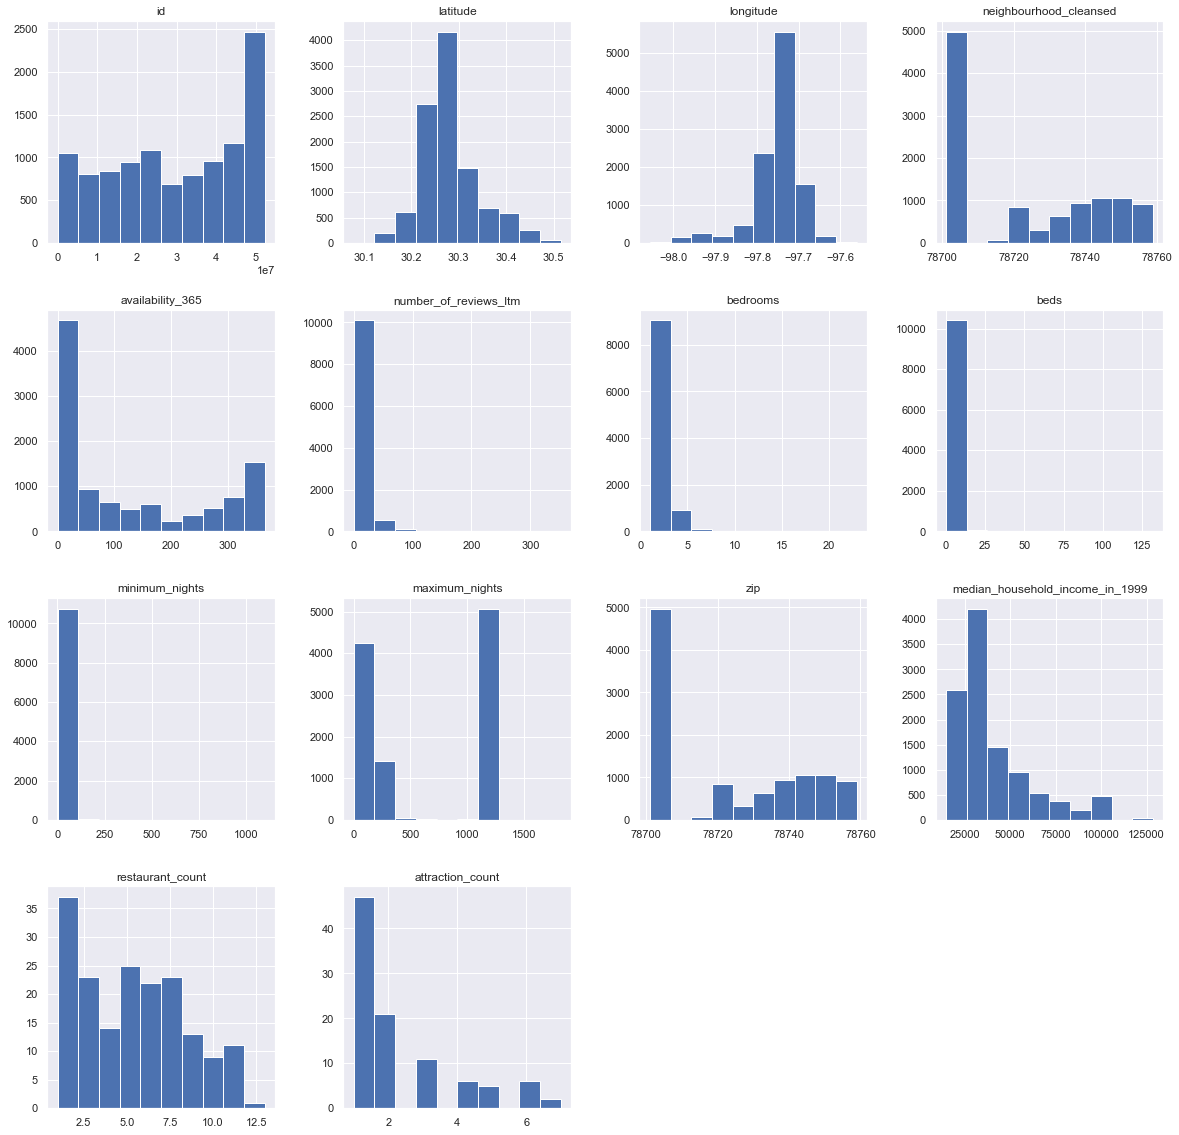

In [12]:
features = ['id', 'latitude', 'longitude', 'neighbourhood_cleansed', 'price',
       'availability_365', 'number_of_reviews_ltm', 'property_type',
       'room_type', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'minimum_nights', 'maximum_nights', 'zip',
       'median_household_income_in_1999', 'restaurant_count',
       'attraction_count']

airbnbDF[features].hist(figsize=(20, 20));

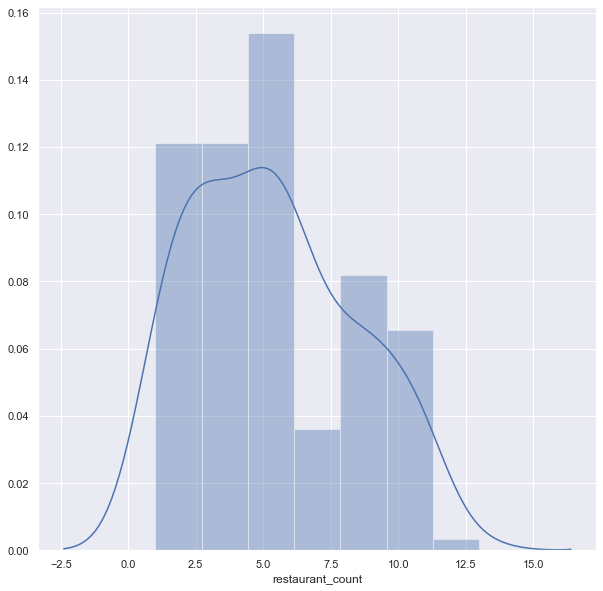

In [13]:
# increasing the width of the Chart
import seaborn as sns
plt.rcParams['figure.figsize'] = 10,10 
sns.distplot(airbnbDF["restaurant_count"]) # pass it one variable

# if you are getting warnings related to the package you should use ignore function
import warnings
warnings.filterwarnings ('ignore')

### 2. Multivariate visualization

Multivariate plots allow us to see relationships between two and more different variables, 

#### 2.1 Quantitative–Quantitative

##### 2.1.1 Multicollinearity

It is correlations among the numerical variables in our dataset and important to know that ML algorithms (e.g., regression) may not handle highly correlated input variables well.

In [14]:
# grab numeric columns
num_airbnb = airbnbDF.select_dtypes(exclude='object')

In [15]:
corr = airbnbDF.corr()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.50)]
to_drop

['beds', 'zip', 'median_household_income_in_1999']

In [16]:
corr['median_household_income_in_1999'].sort_values(ascending=False).head(10).values

array([ 1.        ,  0.35077183,  0.35077183,  0.27083827,  0.14182123,
        0.10654038,  0.10447672,  0.036823  ,  0.02509401, -0.02689329])

In [17]:
corr['median_household_income_in_1999'].sort_values(ascending=False).head(15)

median_household_income_in_1999    1.000000
zip                                0.350772
neighbourhood_cleansed             0.350772
latitude                           0.270838
bedrooms                           0.141821
beds                               0.106540
availability_365                   0.104477
minimum_nights                     0.036823
id                                 0.025094
maximum_nights                    -0.026893
number_of_reviews_ltm             -0.037297
attraction_count                  -0.257169
restaurant_count                  -0.331162
longitude                         -0.648742
Name: median_household_income_in_1999, dtype: float64

##### 2.1.2 Correlation matrix

In [18]:
# Create correlation matrix
correlation_matrix = airbnbDF.corr().abs()
correlation_matrix

,id,latitude,longitude,neighbourhood_cleansed,availability_365,number_of_reviews_ltm,bedrooms,beds,minimum_nights,maximum_nights,zip,median_household_income_in_1999,restaurant_count,attraction_count
id,1.000000,0.045005,0.011520,0.092903,0.245083,0.019337,0.024869,0.046721,0.059857,0.044511,0.092851,0.025094,0.012042,0.075339
latitude,0.045005,1.000000,0.062642,0.245114,0.079886,0.016102,0.010570,0.001208,0.048392,0.011773,0.245123,0.270838,0.213793,0.199352
longitude,0.011520,0.062642,1.000000,0.086990,0.103946,0.011840,0.136786,0.122425,0.001491,0.016442,0.086976,0.648742,0.023411,0.207839
neighbourhood_cleansed,0.092903,0.245114,0.086990,1.000000,0.092373,0.050070,0.023698,0.036702,0.067348,0.009974,1.000000,0.350772,0.405956,0.303788
availability_365,0.245083,0.079886,0.103946,0.092373,1.000000,0.141386,0.131595,0.162495,0.155552,0.051879,0.092331,0.104477,0.068421,0.101150
number_of_reviews_ltm,0.019337,0.016102,0.011840,0.050070,0.141386,1.000000,0.016300,0.051492,0.104487,0.022836,0.050096,0.037297,0.143818,0.129459
bedrooms,0.024869,0.010570,0.136786,0.023698,0.131595,0.016300,1.000000,0.760669,0.040749,0.021212,0.023742,0.141821,0.095959,0.063128
beds,0.046721,0.001208,0.122425,0.036702,0.162495,0.051492,0.760669,1.000000,0.043937,0.035405,0.036732,0.106540,0.036665,0.047329
minimum_nights,0.059857,0.048392,0.001491,0.067348,0.155552,0.104487,0.040749,0.043937,1.000000,0.023876,0.067334,0.036823,0.204067,0.205975
maximum_nights,0.044511,0.011773,0.016442,0.009974,0.051879,0.022836,0.021212,0.035405,0.023876,1.000000,0.009922,0.026893,0.153527,0.124619


In [19]:
# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
upper

,id,latitude,longitude,neighbourhood_cleansed,availability_365,number_of_reviews_ltm,bedrooms,beds,minimum_nights,maximum_nights,zip,median_household_income_in_1999,restaurant_count,attraction_count
id,NaN,0.045005,0.011520,0.092903,0.245083,0.019337,0.024869,0.046721,0.059857,0.044511,0.092851,0.025094,0.012042,0.075339
latitude,NaN,NaN,0.062642,0.245114,0.079886,0.016102,0.010570,0.001208,0.048392,0.011773,0.245123,0.270838,0.213793,0.199352
longitude,NaN,NaN,NaN,0.086990,0.103946,0.011840,0.136786,0.122425,0.001491,0.016442,0.086976,0.648742,0.023411,0.207839
neighbourhood_cleansed,NaN,NaN,NaN,NaN,0.092373,0.050070,0.023698,0.036702,0.067348,0.009974,1.000000,0.350772,0.405956,0.303788
availability_365,NaN,NaN,NaN,NaN,NaN,0.141386,0.131595,0.162495,0.155552,0.051879,0.092331,0.104477,0.068421,0.101150
number_of_reviews_ltm,NaN,NaN,NaN,NaN,NaN,NaN,0.016300,0.051492,0.104487,0.022836,0.050096,0.037297,0.143818,0.129459
bedrooms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.760669,0.040749,0.021212,0.023742,0.141821,0.095959,0.063128
beds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043937,0.035405,0.036732,0.106540,0.036665,0.047329
minimum_nights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023876,0.067334,0.036823,0.204067,0.205975
maximum_nights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009922,0.026893,0.153527,0.124619


In [20]:
# Find index of feature columns with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
to_drop

['beds', 'zip', 'median_household_income_in_1999']

<AxesSubplot:>

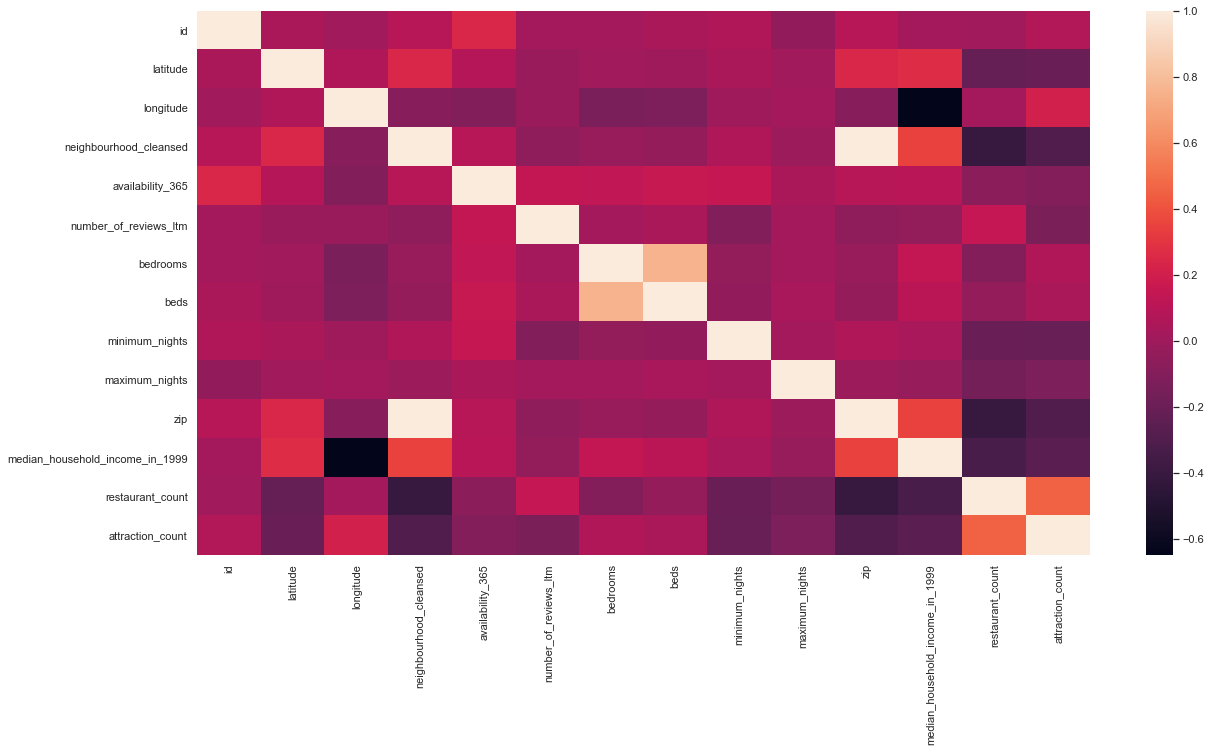

In [21]:
#### 4.2 Correlation heatmap of the numberic variables
plt.rcParams['figure.figsize'] = 20,10  # control plot sizeimport seaborn as sns
sns.heatmap(airbnbDF.corr())

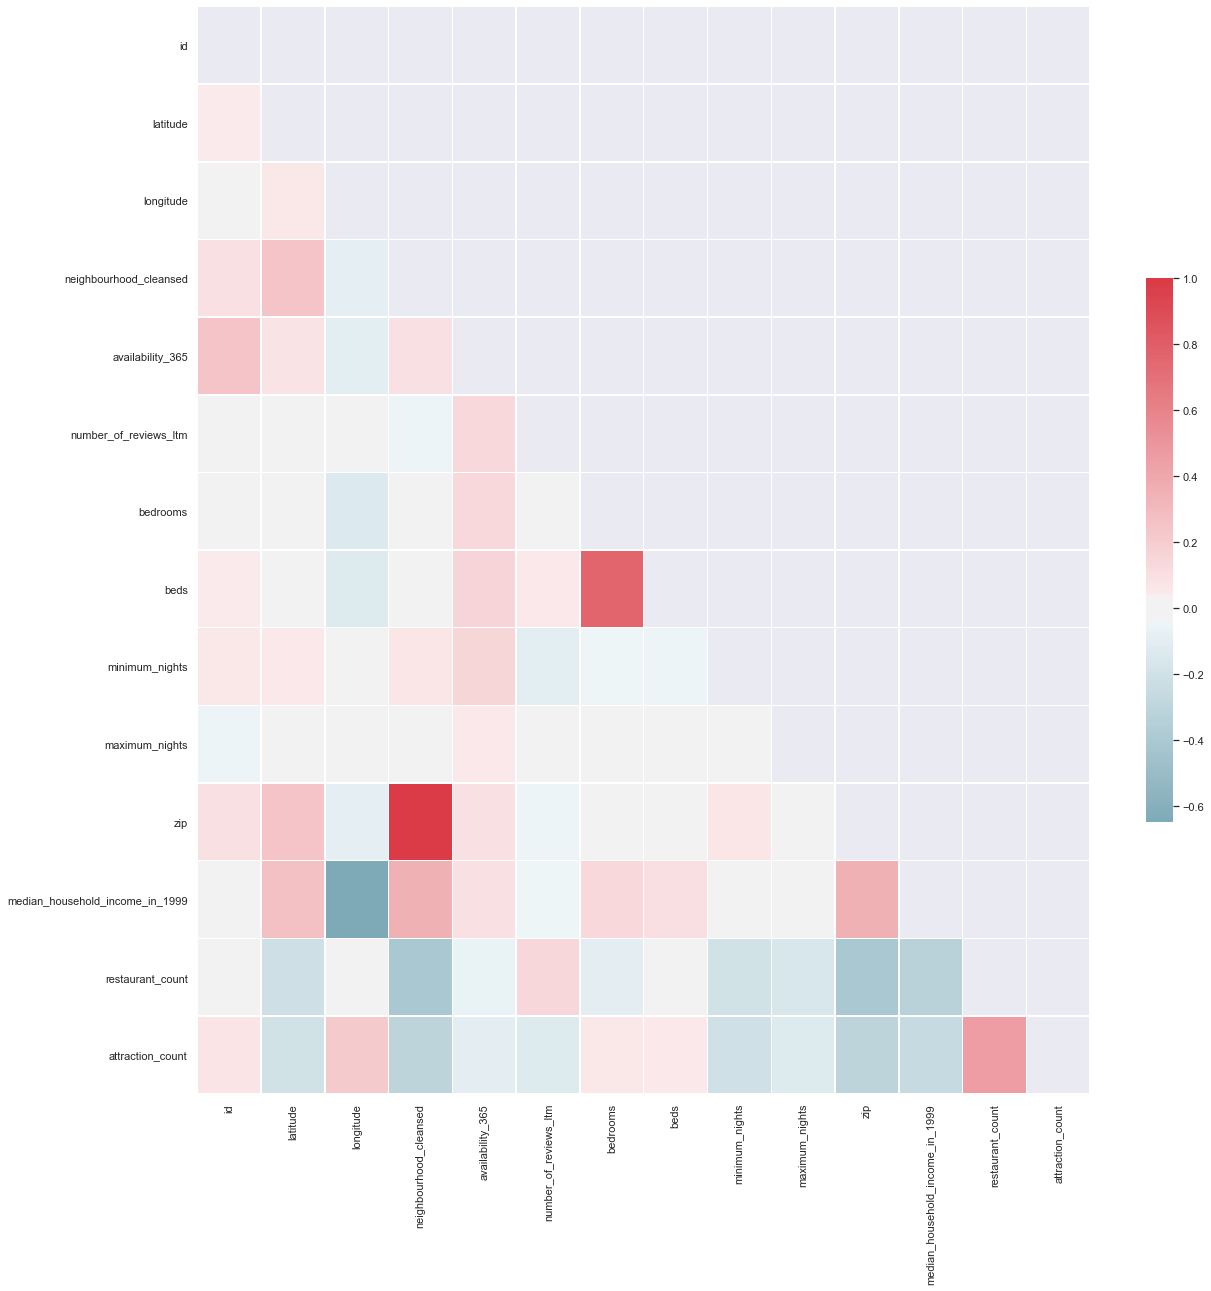

In [22]:
# seaborn
## first_twenty = har_train.iloc[:, :20] # pull out first 20 feats
correlation = airbnbDF.corr()  # compute correlation matrix
mask = np.zeros_like(correlation, dtype=np.bool)  # make mask
mask[np.triu_indices_from(mask)] = True  # mask the upper triangle

fig, ax = plt.subplots(figsize=(20, 20))  # create a figure and a subplot
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # custom color map
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    linewidth=0.5,
    cbar_kws={'shrink': 0.5}
);

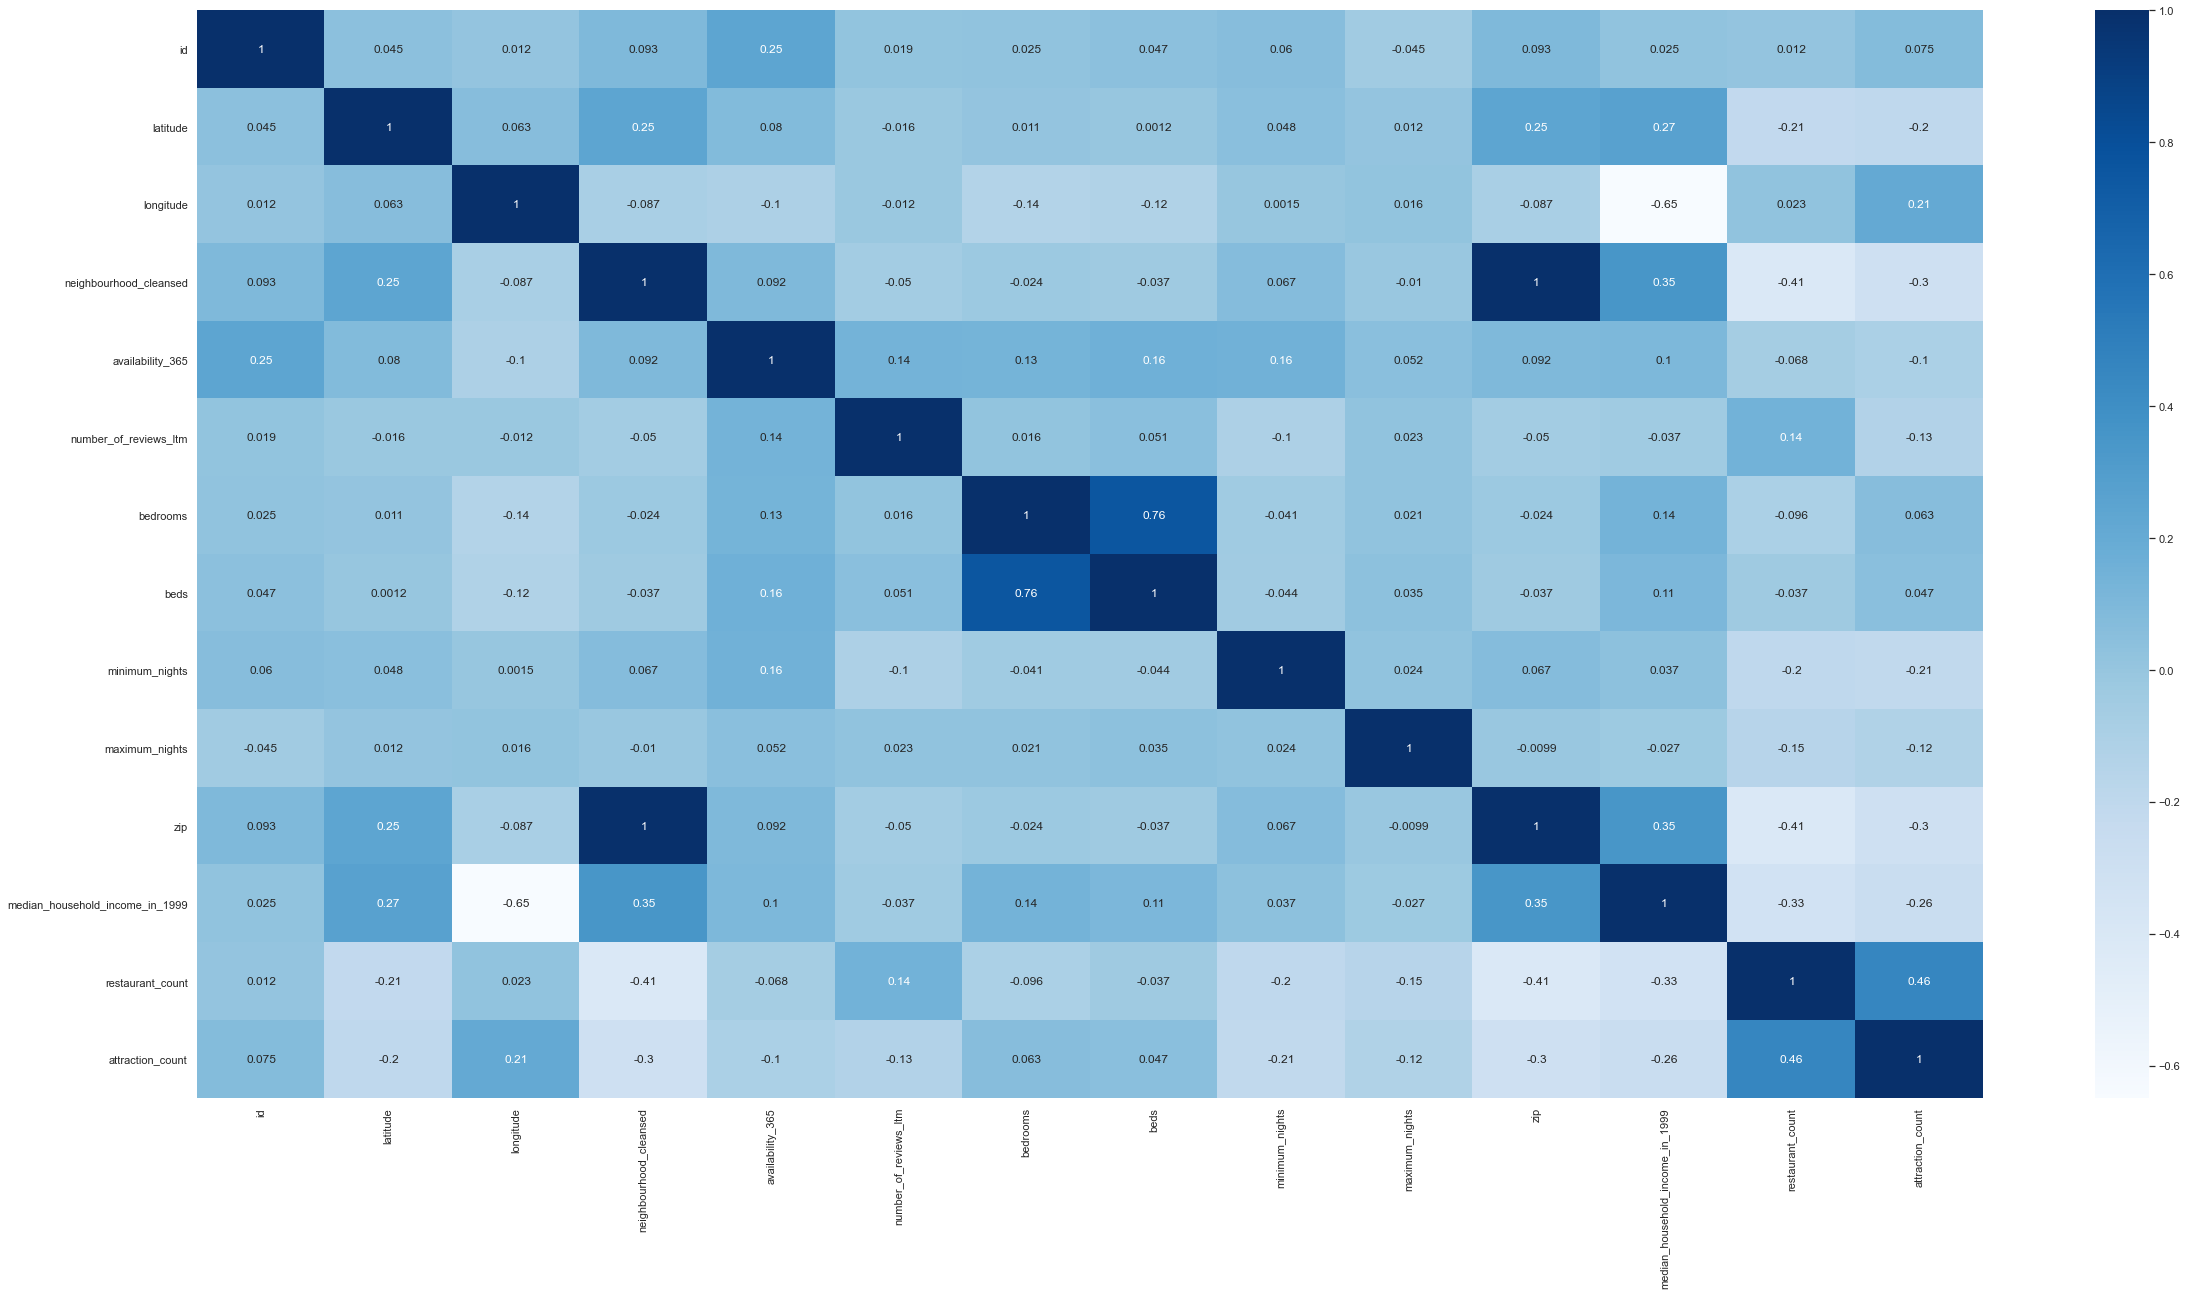

In [23]:
fig, ax = plt.subplots(figsize=(40,20))
sns.heatmap(num_airbnb.corr(), cmap='Blues', annot=True, ax=ax);

<AxesSubplot:>

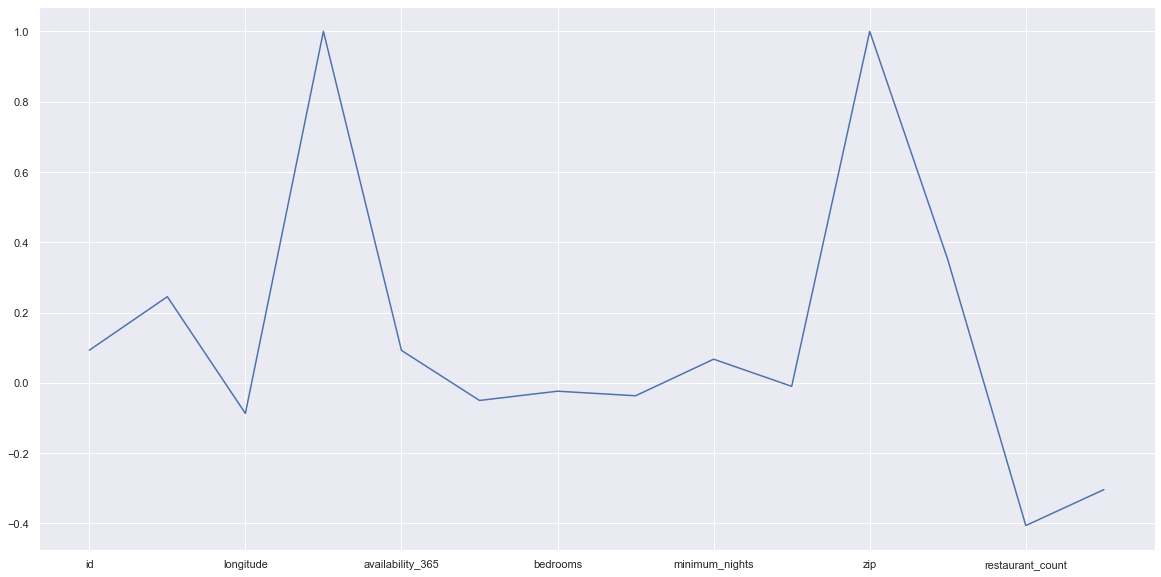

In [24]:
# Correlation with Target Variable

airbnbDF.corr()['zip'].plot()
#autinsurance.corr().plot()

<h4>Pandas scatter matrix function helps visualize the relationship between features</h4>
Use with care though, because it is processor intensive

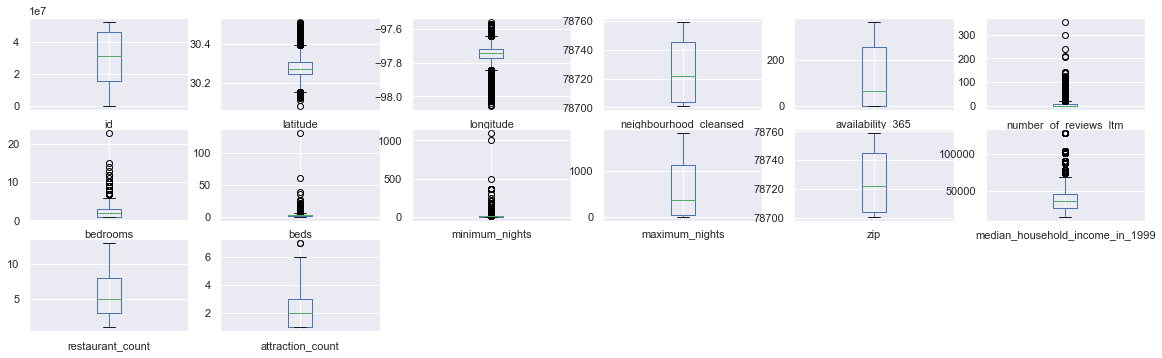

In [25]:
# Box and Whisker Plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20,20  # control plot size
airbnbDF.plot(kind='box', subplots=True, layout=(10,6), sharex=False, sharey=False)
plt.show()

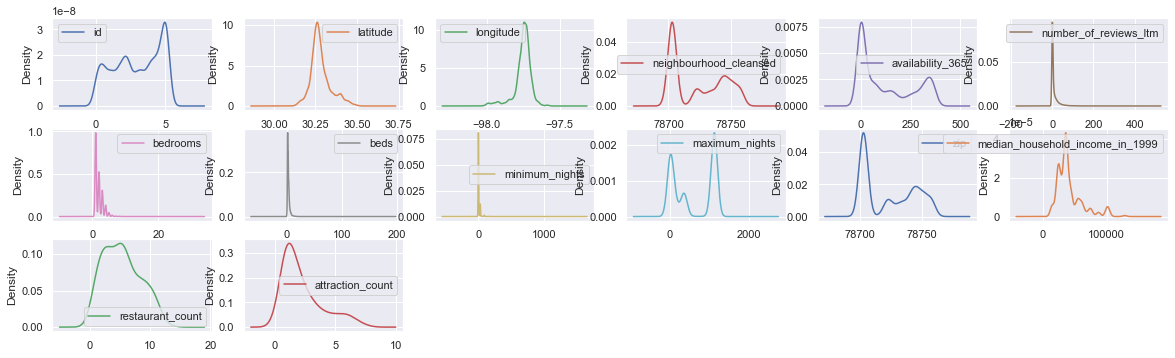

In [26]:
# Univariate Density Plots
plt.rcParams['figure.figsize'] = 20,20  # control plot size

airbnbDF.plot(kind='density', subplots=True, layout=(10,6), sharex=False)
plt.show()

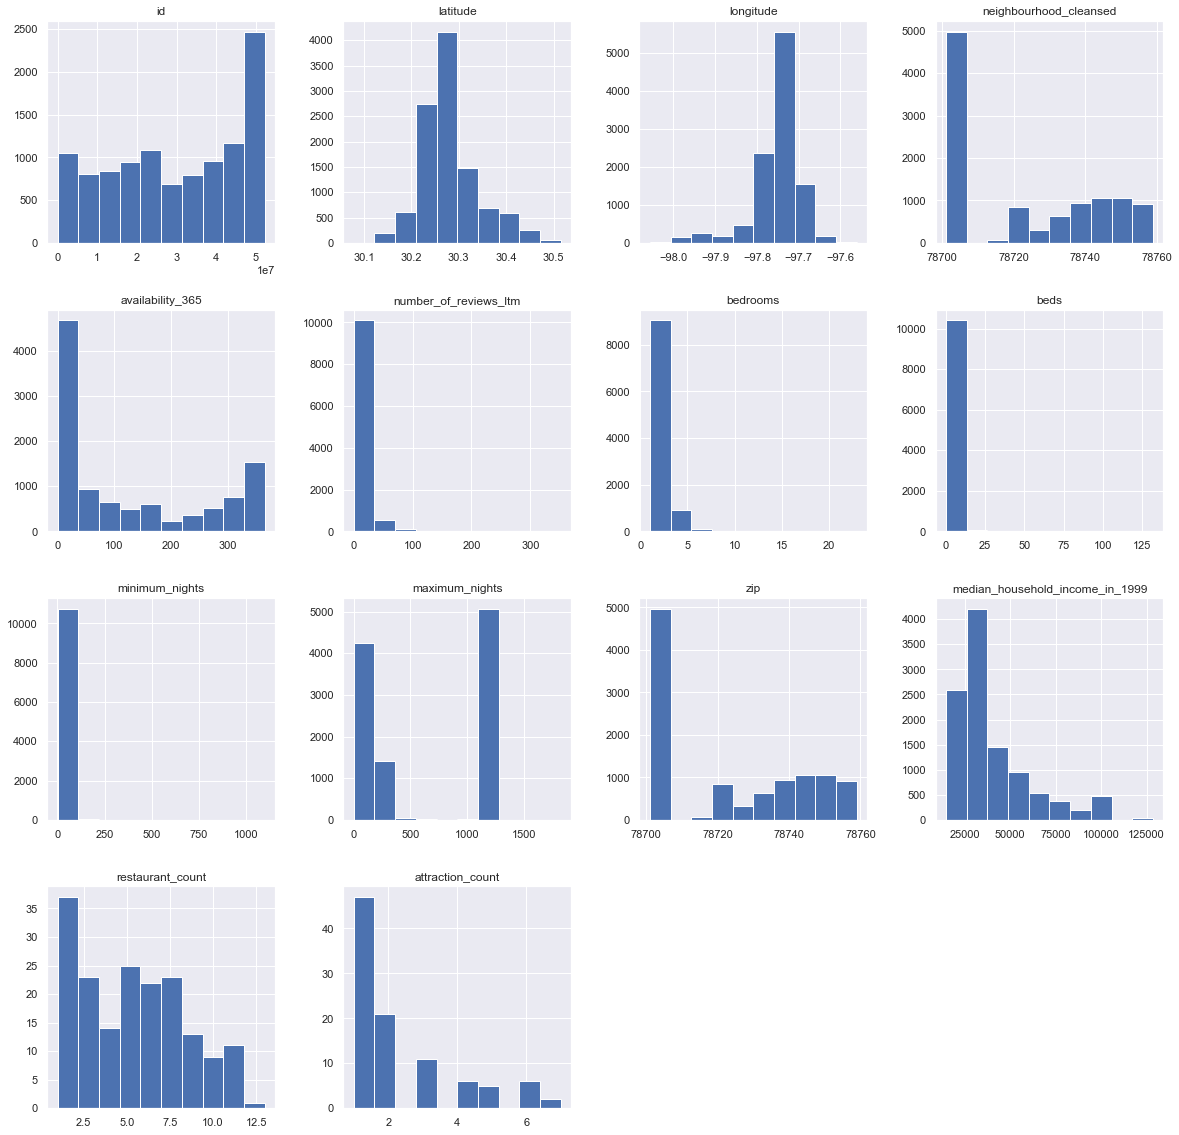

In [27]:
# Univariate Histograms
plt.rcParams['figure.figsize'] = 20,20  # control plot size

airbnbDF.hist()
plt.show()

##### 2.1.2 Scatter plot

The *scatter plot* displays values of two numerical variables as *Cartesian coordinates* in 2D space. Scatter plots in 3D are also possible.

Let's try out the function [`scatter()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.scatter.html) from the `matplotlib` library:

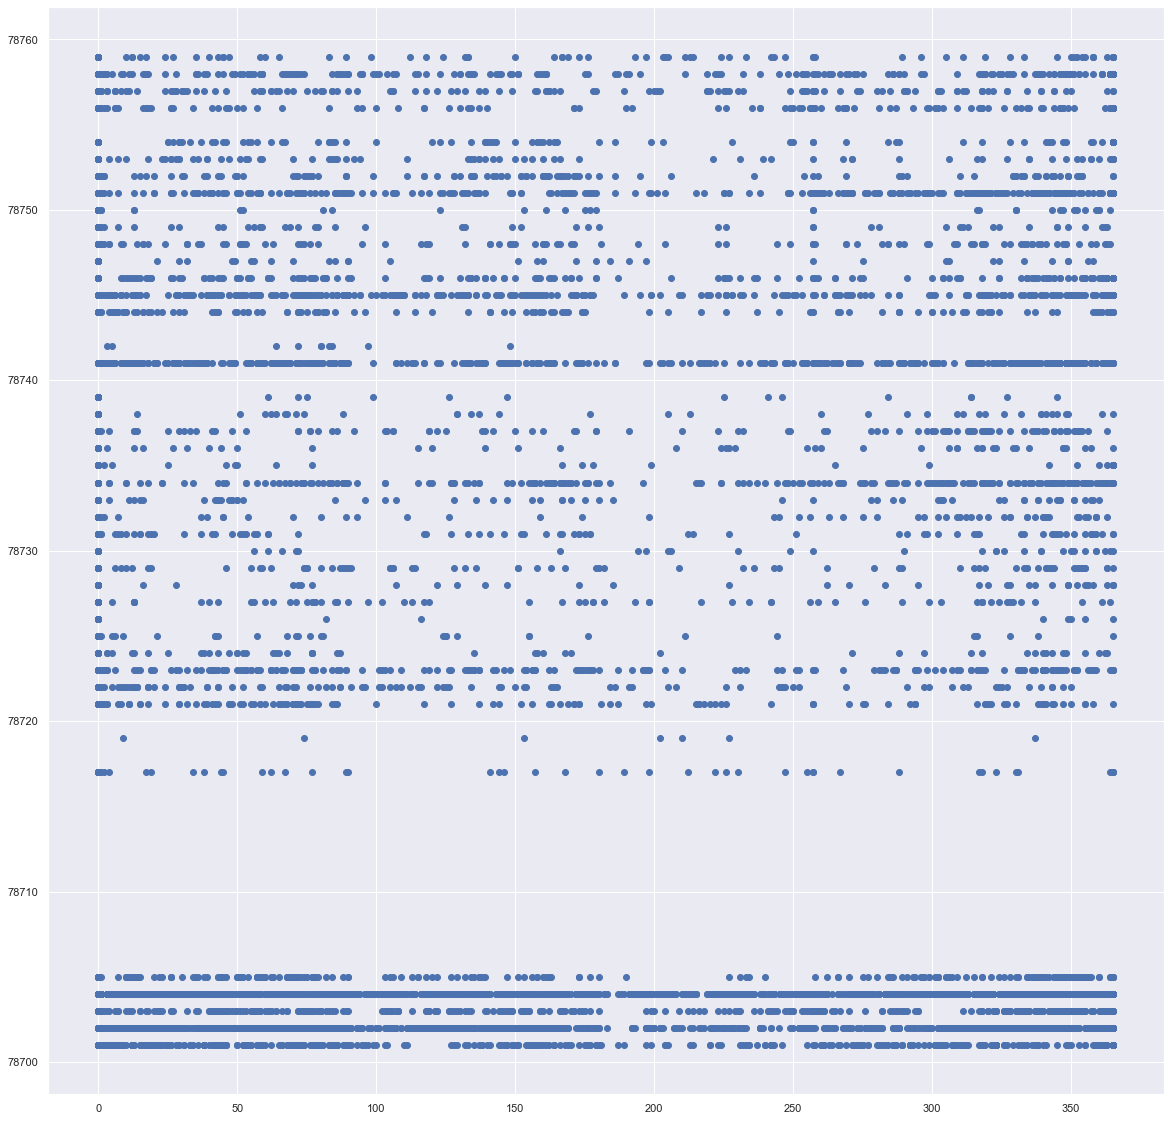

In [28]:
plt.scatter(airbnbDF['availability_365'], airbnbDF['zip']);

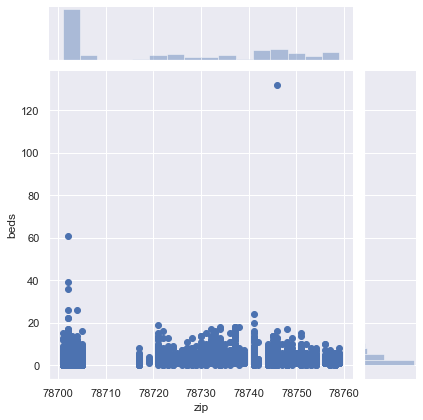

In [29]:
sns.jointplot(x='zip', y='beds', 
              data=airbnbDF, kind='scatter');

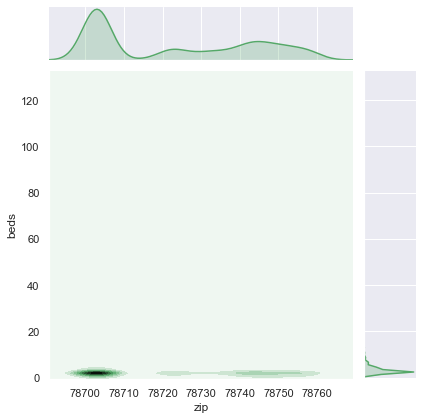

In [30]:
sns.jointplot('zip', 'beds', data=airbnbDF,
              kind="kde", color="g");

<a id="III"></a>
# III- Data  Preparation

Preprocessing and exploring data is time consuming. In the interest of brevity, you'll focus on a subset of features. After extracting the desired features, you will partition the data into *training* and *testing* sets. This is a standard practice for any data science project.

In [31]:
# check the data types

print(airbnbDF.columns)
print(airbnbDF.dtypes)

Index(['id', 'latitude', 'longitude', 'neighbourhood_cleansed', 'price',
       'availability_365', 'number_of_reviews_ltm', 'property_type',
       'room_type', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'minimum_nights', 'maximum_nights', 'zip',
       'median_household_income_in_1999', 'restaurant_count',
       'attraction_count'],
      dtype='object')
id                                   int64
latitude                           float64
longitude                          float64
neighbourhood_cleansed               int64
price                               object
availability_365                     int64
number_of_reviews_ltm                int64
property_type                       object
room_type                           object
bathrooms_text                      object
bedrooms                           float64
beds                               float64
amenities                           object
minimum_nights                       int64
maximum_nights         

In [43]:
#airbnbDF["price"] = airbnbDF["price"].str.strip()
#airbnbDF["price"] = airbnbDF["price"].str.strip("$")
#airbnbDF["price"] = airbnbDF["price"].str.strip(",")
#print(airbnbDF["price"])
#dfs = airbnbDF.sort_values(['price'], ascending=False)
#print(dfs)

            id   latitude  longitude  neighbourhood_cleansed     price  \
6591  38741043  30.304260 -97.720240                   78751    999.00   
6453  38099791  30.299910 -97.682650                   78723    999.00   
1899  10751717  30.240560 -97.733010                   78741    999.00   
1063   5251600  30.260520 -97.733430                   78702    999.00   
4517  23807370  30.274890 -97.727870                   78702    999.00   
...        ...        ...        ...                     ...       ...   
4622  24822761  30.457390 -97.777750                   78729  1,000.00   
4084  22843720  30.235573 -97.765991                   78704  1,000.00   
3744  21173557  30.356740 -97.717940                   78757  1,000.00   
8083  45895289  30.251623 -97.746515                   78704      0.00   
7471  42738847  30.301810 -97.829100                   78746      0.00   

      availability_365  number_of_reviews_ltm            property_type  \
6591               168               

In [45]:
airbnbDF["price"] = (airbnbDF["price"].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))
print(airbnbDF["price"])

0        200.0
1        114.0
2        104.0
3         39.0
4        109.0
         ...  
10804    112.0
10805    349.0
10806    349.0
10807    214.0
10808    120.0
Name: price, Length: 10809, dtype: float64


## Multicollinearity

In [49]:
corr = airbnbDF.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.50)]
to_drop

['beds', 'zip', 'median_household_income_in_1999']

In [50]:
corr['median_household_income_in_1999'].sort_values(ascending=False).head(10).values

array([1.        , 0.35077183, 0.35077183, 0.27083827, 0.14182123,
       0.12982715, 0.10654038, 0.10447672, 0.036823  , 0.02509401])

In [51]:
corr['median_household_income_in_1999'].sort_values(ascending=False).head(15)

median_household_income_in_1999    1.000000
zip                                0.350772
neighbourhood_cleansed             0.350772
latitude                           0.270838
bedrooms                           0.141821
price                              0.129827
beds                               0.106540
availability_365                   0.104477
minimum_nights                     0.036823
id                                 0.025094
maximum_nights                    -0.026893
number_of_reviews_ltm             -0.037297
attraction_count                  -0.257169
restaurant_count                  -0.331162
longitude                         -0.648742
Name: median_household_income_in_1999, dtype: float64

###  1. Fixing missing values

A value near **-1** means if one variable appears then the other variable is very likely to be missing.  
A value near **0** means there is no dependence between the occurrence of missing values of two variables.  
A value near **1** means if one variable appears then the other variable is very likely to be present.  

In [59]:
airbnbDF.describe()

,id,latitude,longitude,neighbourhood_cleansed,price,availability_365,number_of_reviews_ltm,bedrooms,beds,minimum_nights,maximum_nights,zip,median_household_income_in_1999,restaurant_count,attraction_count
count,1.080900e+04,10809.000000,10809.000000,10809.000000,10809.000000,10809.000000,10809.000000,10099.000000,10488.000000,10809.000000,10809.000000,10808.000000,10808.000000,178.000000,98.000000
mean,2.970668e+07,30.280706,-97.752166,78723.682117,277.809692,123.961421,8.252105,1.940291,2.484554,8.286983,594.888241,78723.683198,41428.056532,5.353933,2.255102
std,1.671904e+07,0.060925,0.059764,20.955117,521.438354,136.146270,17.168048,1.241449,2.601785,25.269037,512.023606,20.955785,20468.892621,3.009122,1.657916
min,2.265000e+03,30.078870,-98.056630,78701.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,78701.000000,14740.000000,1.000000,1.000000
25%,1.580218e+07,30.244220,-97.770100,78704.000000,95.000000,0.000000,0.000000,1.000000,1.000000,1.000000,30.000000,78704.000000,26646.000000,3.000000,1.000000
50%,3.116931e+07,30.269210,-97.744030,78722.000000,150.000000,65.000000,0.000000,2.000000,2.000000,2.000000,365.000000,78722.000000,35733.000000,5.000000,2.000000
75%,4.598770e+07,30.305490,-97.719990,78745.000000,282.000000,259.000000,9.000000,3.000000,3.000000,3.000000,1125.000000,78745.000000,45090.000000,8.000000,3.000000
max,5.225487e+07,30.515090,-97.560620,78759.000000,12980.000000,365.000000,352.000000,23.000000,132.000000,1100.000000,1825.000000,78759.000000,128524.000000,13.000000,7.000000


In [60]:
airbnbDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10809 entries, 0 to 10808
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               10809 non-null  int64  
 1   latitude                         10809 non-null  float64
 2   longitude                        10809 non-null  float64
 3   neighbourhood_cleansed           10809 non-null  int64  
 4   price                            10809 non-null  float32
 5   availability_365                 10809 non-null  int64  
 6   number_of_reviews_ltm            10809 non-null  int64  
 7   property_type                    10809 non-null  object 
 8   room_type                        10809 non-null  object 
 9   bathrooms_text                   10794 non-null  object 
 10  bedrooms                         10099 non-null  float64
 11  beds                             10488 non-null  float64
 12  amenities         

In [61]:
airbnbDF.isna().sum()

id                                     0
latitude                               0
longitude                              0
neighbourhood_cleansed                 0
price                                  0
availability_365                       0
number_of_reviews_ltm                  0
property_type                          0
room_type                              0
bathrooms_text                        15
bedrooms                             710
beds                                 321
amenities                              0
minimum_nights                         0
maximum_nights                         0
zip                                    1
median_household_income_in_1999        1
restaurant_count                   10631
attraction_count                   10711
dtype: int64

In [56]:
#pip install missingno

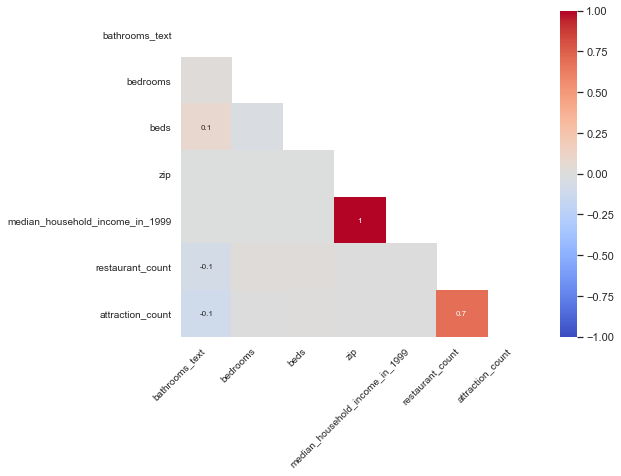

In [57]:
# Visualize the correlation between the number of 
# missing values in different columns as a heatmap 

import missingno as msval
msval.heatmap(airbnbDF, cmap='coolwarm', figsize=(8,6), fontsize=10);

<AxesSubplot:>

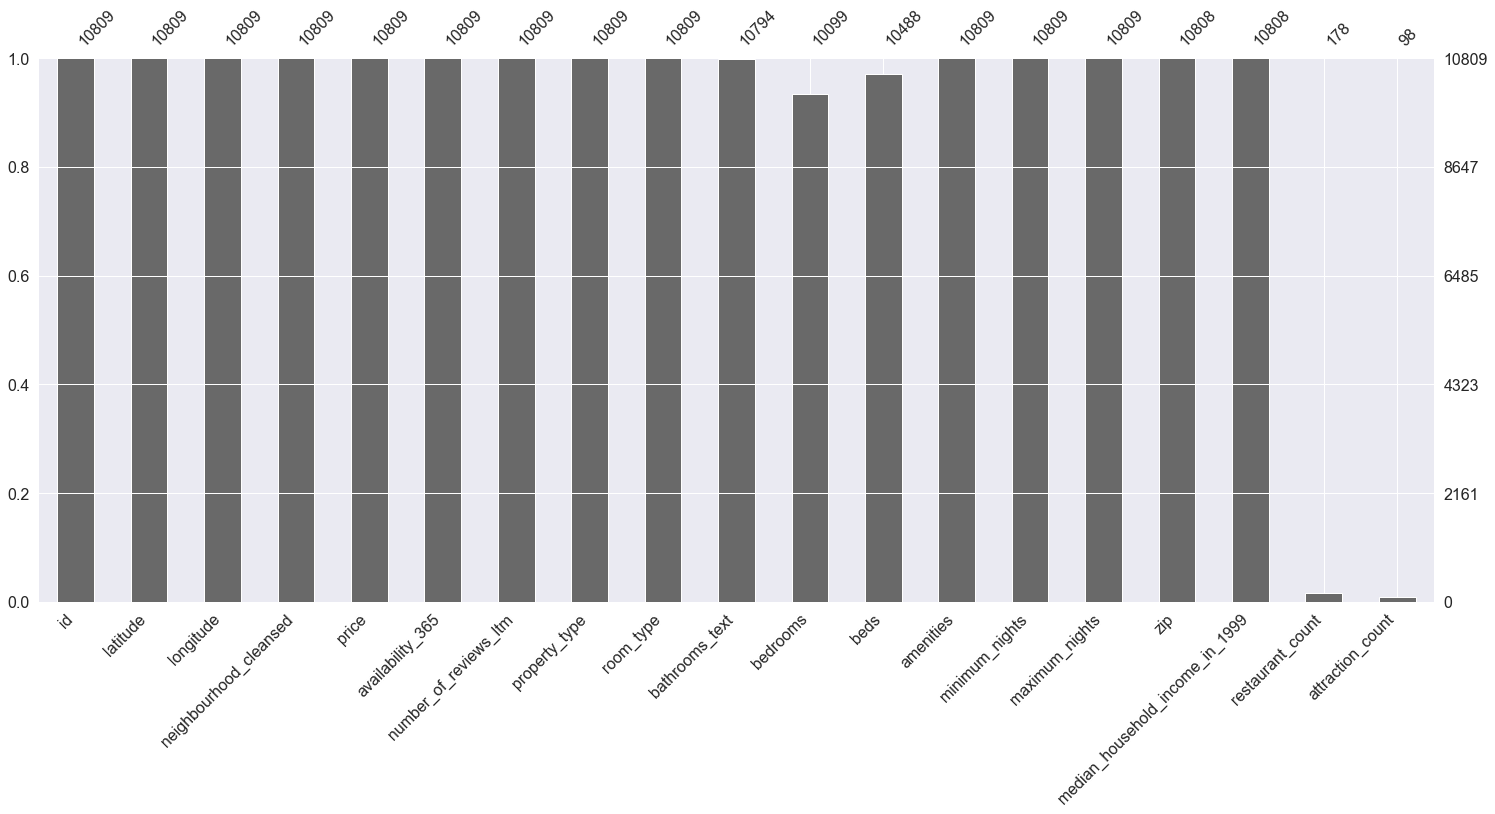

In [66]:
msval.bar(airbnbDF)

<AxesSubplot:>

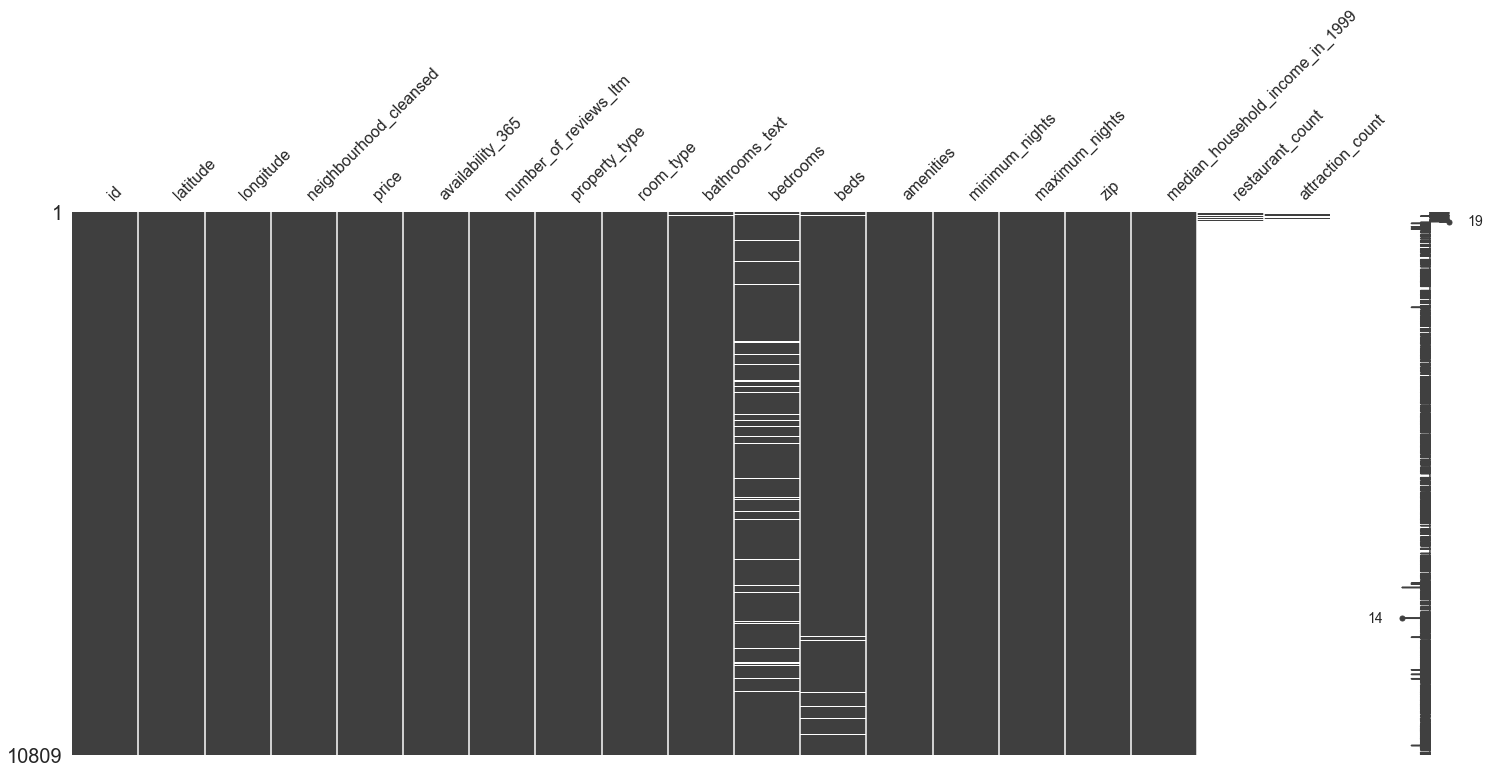

In [67]:
msval.matrix(airbnbDF)

<h2 id="t1" style="margin-bottom: 18px">Data split & Scaling Data Preprocessing</h2>


In [47]:
 X = airbnbDF.drop('availability_365', axis = 1)
 y = airbnbDF.availability_365

In [48]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

training_features, test_features, \
training_target, test_target, = train_test_split(airbnbDF.drop('availability_365', axis = 1),
                                               airbnbDF.availability_365,
                                               test_size = .2,
                                               random_state=12)


<h2 id="t1" style="margin-bottom: 18px">Machine Learning</h2>

In [ ]:
# Confusion Matrix
#from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Using a Dummy Classifier

from sklearn.dummy import DummyClassifier
dummy_baseline = DummyClassifier(strategy="most_frequent")
dummy_baseline.fit(test_features, test_target)

DummyClf = dummy_baseline.score(test_features, test_target)
DummyClf

In [ ]:
# Create classifiers

DTModel    = DecisionTreeClassifier(criterion = 'entropy', random_state = 45)
NBModel    = GaussianNB()
LRModel    = LogisticRegression(random_state = 45, solver='newton-cg', max_iter=1000)
SVMModel   = SVC(kernel = 'linear', random_state = 45)
KSVMModel  = SVC(kernel = 'rbf', random_state = 45)
KNNModel   = KNeighborsClassifier(n_neighbors = 57)#  , metric = 'minkowski', p = 2
RFModel    = RandomForestClassifier( n_estimators=87, random_state=45)
BModel     = BaggingClassifier(tree.DecisionTreeClassifier(random_state=45))
ADBModel   = AdaBoostClassifier(random_state=45)
GBModel    = GradientBoostingClassifier(random_state=45)
ExTrModel  = ExtraTreesClassifier(random_state=45)
RCModel    = RidgeClassifier(random_state=45)
#CatBModel  = CatBoostClassifier(iterations=250, depth=6, learning_rate=0.1, loss_function='CrossEntropy', random_state = 45)
SGDModel   = SGDClassifier(random_state = 45) 

In [ ]:
# Fit Decision Tree
DTModel.fit(training_features, training_target)
DTPred = DTModel.predict(test_features)
ADT = DTModel.score(test_features, test_target)

In [ ]:
# Fit Naive Bayes
NBModel.fit(training_features, training_target)
NB_pred = NBModel.predict(test_features)
ACNB= accuracy_score(test_target, NB_pred)

In [ ]:
# Fit Logistic Regression
LRModel.fit(training_features, training_target)
LR_pred =LRModel.predict(test_features)
ACLR= accuracy_score(test_target, LR_pred )

In [ ]:
# SVMModel.fit(training_features, training_target)
# SVM_pred = SVMModel.predict(test_features)
# ACSVM= accuracy_score(test_target, SVM_pred )

In [ ]:
# Fit Kernel Support Vector Machine
KSVMModel.fit(training_features, training_target)
KSVM_pred = KSVMModel.predict(test_features)
ACKSVM= accuracy_score(test_target, KSVM_pred )

In [ ]:
# Fit KNN
KNNModel.fit(training_features, training_target)
KNN_pred = KNNModel.predict(test_features)
ACKNN= accuracy_score(test_target, KNN_pred )

In [ ]:
# Fit Random Forest
RFModel.fit(training_features, training_target)
RF_pred = RFModel.predict(test_features)
ACRF= accuracy_score(test_target, RF_pred )

In [ ]:
# Fit Bagging
BModel.fit(training_features, training_target)
Bagg_pred = BModel.predict(test_features)
ACBagg= accuracy_score(test_target, Bagg_pred )

In [ ]:
# Fit AdaBoost
ADBModel.fit(training_features, training_target)
ADB_pred = ADBModel.predict(test_features)
ACADB = accuracy_score(test_target, ADB_pred )

In [ ]:
# Fit Gradient Boosting
GBModel.fit(training_features, training_target)
GB_pred = GBModel.predict(test_features)
ACGB= accuracy_score(test_target, GB_pred )

In [ ]:
# Fit Extra Tree
ExTrModel.fit(training_features, training_target)
ExTr_pred = ExTrModel.predict(test_features)
ACExTr= accuracy_score(test_target, ExTr_pred )

In [ ]:
# Fit Ridge Classifier
RCModel.fit(training_features, training_target)
RC_pred = RCModel.predict(test_features)
ACRC= accuracy_score(test_target, RC_pred )

In [ ]:
# Fit Catboost
SGDModel.fit(training_features, training_target)
SGD_pred=SGDModel.predict(test_features)
ACCSGD= accuracy_score(test_target, SGD_pred )

In [ ]:
# # Fit Catboost
# CatBModel.fit(training_features, training_target)
# CatB_pred=CatBModel.predict(test_features)
# ACCatB= accuracy_score(test_target, CatB_pred )

In [ ]:
print(' The fraction of correct classifications is            : {:.2f}%'.format(DummyClf * 100))
print(" Logistic Regression Prediction Accuracy               : {:.2f}%".format(ACLR * 100))
#print(" Support Vector Machine Prediction Accuracy            : {:.2f}%".format(ACSVM * 100))
print(" Ensemble - Ada-Boost Prediction Accuracy              : {:.2f}%".format(ACADB * 100))
print(" Random Forest Prediction Accuracy                     : {:.2f}%".format(ACRF * 100))
print(" Ridge Classifier Prediction Accuracy                  : {:.2f}%".format(ACRC * 100))
print(" Ensemble - Bagging Prediction Accuracy                : {:.2f}%".format(ACBagg * 100))
print(" Ensemble - Gradient Boosting Prediction Accuracy      : {:.2f}%".format(ACGB * 100))
print(" Ensemble - ExtraTrees Prediction Accuracy             : {:.2f}%".format(ACExTr * 100))
#print(" Ensemble - CatBoost                                   : {:.2f}%".format(ACCatB * 100))
print(" K- Support Vector Machine Prediction Accuracy         : {:.2f}%".format(ACKSVM * 100))
print(" Decision Tree Prediction Accuracy                     : {:.2f}%".format(ADT * 100))
print(" Naive Bayes Prediction Accuracy                       : {:.2f}%".format(ACNB * 100))
print(" k Nearest Neighbors Prediction Accuracy               : {:.2f}%".format(ACKNN * 100))
print(" Stochastic Gradient Descent Prediction Accuracy       : {:.2f}%".format(ACKNN * 100))


<h2 id="t5">Random under-sampling</h2>

In [ ]:
# Class count
#df_train = autinsurance
count_class_0, count_class_1 = autinsurance.fraud_reported.value_counts()

# Divide by class
df_class_0 = autinsurance[autinsurance['fraud_reported'] == 0]
df_class_1 = autinsurance[autinsurance['fraud_reported'] == 1]

In [ ]:
print(count_class_0)
print(count_class_1)

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_class_0_under.shape

In [ ]:
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
df_test_under.shape

In [ ]:
print('Random under-sampling:')
print(df_test_under.fraud_reported.value_counts())

df_test_under.fraud_reported.value_counts().plot(kind='bar', title='Count (fraud_reported)');

In [ ]:
 X = df_test_under.drop('fraud_reported', axis = 1)
 y = df_test_under.fraud_reported

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

training_features_under, test_features_under, \
training_target_under, test_target_under, = train_test_split(df_test_under.drop('fraud_reported', axis = 1),
                                               df_test_under.fraud_reported,
                                               test_size = .2,
                                               random_state=12)


<h2 id="t6">Random over-sampling</h2>

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_1_over.shape

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.fraud_reported.value_counts())

df_test_over.fraud_reported.value_counts().plot(kind='bar', title='Count (fraud_reported)');

In [ ]:
 X = df_test_over.drop('fraud_reported', axis = 1)
 y = df_test_over.fraud_reported

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

training_features_over, test_features_over, \
training_target_over, test_target_over, = train_test_split(df_test_over.drop('fraud_reported', axis = 1),
                                               df_test_over.fraud_reported,
                                               test_size = .2,
                                               random_state=12)


<h2 id="t7" style="margin-bottom: 18px">Overlaid ROC curves</h2>

Here's the full example.
* If you have more models, you can also put this process in a loop.

In [ ]:
# For calculating AUROC
from sklearn.metrics import roc_curve, auc

In [ ]:
# Initialize plot
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

#########################################################
# ---- DT---- #
#########################################################
# Predicts X_test using model
DT_pred = DTModel.predict_proba(test_features)
DT_pred = [p[1] for p in DT_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, DT_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('Decision Tree', auroc))


#########################################################
# ---- KNN ---- #
#########################################################

# Predicts test_features using model
KNN_pred = KNNModel.predict_proba(test_features)
KNN_pred = [p[1] for p in KNN_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, KNN_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('KNN', auroc))


#########################################################
# ---- NB---- #
#########################################################

# Predicts test_features using model
NB_pred = NBModel.predict_proba(test_features)
NB_pred = [p[1] for p in NB_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, NB_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('NB', auroc))



#########################################################
# ---- LR ---- #
#########################################################

# Predicts test_features using model
LR_pred = NBModel.predict_proba(test_features)
LR_pred = [p[1] for p in LR_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, LR_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('LR', auroc))


#########################################################
# ---- RF---- #
#########################################################

# Predicts test_features using model
RF_pred = RFModel.predict_proba(test_features)
RF_pred = [p[1] for p in RF_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, RF_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('RF', auroc))


#########################################################
# ---- Bagging---- #
#########################################################

# Predicts test_features using model
Bagg_pred = BModel.predict_proba(test_features)
Bagg_pred = [p[1] for p in Bagg_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, Bagg_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('Bagging', auroc))


#########################################################
# ---- AdaBoost---- #
#########################################################

# Predicts test_features using model
ADB_pred = ADBModel.predict_proba(test_features)
ADB_pred = [p[1] for p in ADB_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, ADB_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('Ada-Boost', auroc))


#########################################################
# ---- Gradient Boosting---- #
#########################################################

# Predicts test_features using model
GB_pred = GBModel.predict_proba(test_features)
GB_pred = [p[1] for p in GB_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, GB_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('Gradient Boosting', auroc))

#########################################################
# ---- CatBoost---- #
#########################################################

# # Predicts test_features using model
# CatB_pred = CatBModel.predict_proba(test_features)
# CatB_pred = [p[1] for p in CatB_pred]
    
# # Calculates ROC curve
# fpr, tpr, thresholds = roc_curve(test_target, CatB_pred)
    
# # Calculates AUROC
# auroc = round(auc(fpr, tpr), 3)
    
# # Plots ROC curve and labels with AUROC
# plt.plot(fpr, tpr, label='{} AUROC = {}'.format('CatBoosting', auroc))


#########################################################
# ---- Extra-Tree ---- #
#########################################################
# Predicts test_features using model
ExTr_pred = ExTrModel.predict_proba(test_features)
ExTr_pred = [p[1] for p in ExTr_pred]
    
# Calculates ROC curve
fpr, tpr, thresholds = roc_curve(test_target, ExTr_pred)
    
# Calculates AUROC
auroc = round(auc(fpr, tpr), 3)
    
# Plots ROC curve and labels with AUROC
plt.plot(fpr, tpr, label='{} AUROC = {}'.format('Extra Tree', auroc))


# ---- Legend and labels ---- #

# Plot legend
plt.legend(loc='lower right')

# Plots 45 degree dotted black line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate (Split Method)')
plt.xlabel('False Positive Rate (Split Method)')
plt.show()
plt.show()

<h2 id="t1" style="margin-bottom: 18px">Machine Learning - Model Selection Method</h2>

In [ ]:
# Confusion Matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# help(CatBoostClassifier)

In [ ]:
#from sklearn.model_selection import KFold
from sklearn import model_selection

# Spot Check Algorithms
scoring = 'accuracy'
models = []
models.append(('LRM  ', LogisticRegression(random_state = 45, solver='newton-cg', max_iter=1000)))
models.append(('KNN  ', KNeighborsClassifier(n_neighbors = 57  , metric = 'minkowski', p = 2)))
models.append(('CART ', DecisionTreeClassifier(criterion = 'entropy', random_state = 45)))
models.append(('GNB  ', GaussianNB()))
models.append(('KSVM ', SVC(kernel = 'rbf', random_state = 45)))
models.append(('ABM  ', AdaBoostClassifier(random_state=42 , n_estimators=  53, learning_rate = .7, algorithm = 'SAMME.R')))
models.append(('GBM  ', GradientBoostingClassifier()))
models.append(('RFM  ', RandomForestClassifier(n_estimators=80, max_features=7, oob_score= True, random_state= 42)))
models.append(('ExT  ', ExtraTreesClassifier()))
models.append(('SGD ' , SGDClassifier(random_state = 45)))
results = []
names = []
for name, model in models:
    cv_results = model_selection.cross_val_score(model, training_features, training_target,  scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s  : %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<h2 id="t7" style="margin-bottom: 18px">Applying k-Fold Cross Validation</h2>

<img src="grid_search_cross_validation.PNG" />

In [ ]:
 X = autinsurance.drop('fraud_reported', axis = 1)
 y = autinsurance.fraud_reported

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

training_features, test_features, \
training_target, test_target, = train_test_split(autinsurance.drop('fraud_reported', axis = 1),
                                               autinsurance.fraud_reported,
                                               test_size = .2,
                                               random_state=12)


In [ ]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score

DT_Accuracies   = cross_val_score(estimator = DTModel, X    = training_features, y = training_target, cv = 10)
NB_Accuracies   = cross_val_score(estimator = NBModel, X    = training_features, y = training_target, cv = 10)
LR_Accuracies   = cross_val_score(estimator = LRModel, X    = training_features, y = training_target, cv = 10)
KSVM_Accuracies = cross_val_score(estimator = KSVMModel, X  = training_features, y = training_target, cv = 10)
KNN_Accuracies  = cross_val_score(estimator = KNNModel, X   = training_features, y = training_target, cv = 10)
RF_Accuracies   = cross_val_score(estimator = RFModel, X    = training_features, y = training_target, cv = 10)
Bagg_Accuracies = cross_val_score(estimator = BModel, X     = training_features, y = training_target, cv = 10)
ADB_Accuracies  = cross_val_score(estimator = ADBModel, X   = training_features, y = training_target, cv = 10)
GB_Accuracies   = cross_val_score(estimator = GBModel, X    = training_features, y = training_target, cv = 10)
ExTr_Accuracies = cross_val_score(estimator = ExTrModel, X  = training_features, y = training_target, cv = 10)
RC_Accuracies   = cross_val_score(estimator = RCModel, X    = training_features, y = training_target, cv = 10)
SGD_Accuracies  = cross_val_score(estimator = SGDModel, X   = training_features, y = training_target, cv = 10)


In [ ]:
print(" KSVM Accuracy: %0.2f (+/- %0.2f)"  % (KSVM_Accuracies.mean(), KSVM_Accuracies.std() * 2))
print(" ExTr Accuracy: %0.2f (+/- %0.2f)"  % (ExTr_Accuracies.mean(), ExTr_Accuracies.std() * 2))
print(" RF Accuracy:   %0.2f (+/- %0.2f)"  % (RF_Accuracies.mean(), RF_Accuracies.std()     * 2))
print(" Bagg Accuracy: %0.2f (+/- %0.2f)"  % (Bagg_Accuracies.mean(), Bagg_Accuracies.std() * 2))
print(" DT Accuracy:   %0.2f (+/- %0.2f)"  % (DT_Accuracies.mean(), DT_Accuracies.std()     * 2))
print(" LR Accuracy:   %0.2f (+/- %0.2f)"  % (LR_Accuracies.mean(), LR_Accuracies.std()     * 2))
print(" ADB Accuracy:  %0.2f (+/- %0.2f)"  % (ADB_Accuracies.mean(), ADB_Accuracies.std()   * 2))
print(" GB Accuracy:   %0.2f (+/- %0.2f)"  % (GB_Accuracies.mean(),   GB_Accuracies.std()   * 2))
print(" RC Accuracy:   %0.2f (+/- %0.2f)"  % (RC_Accuracies.mean(),   RC_Accuracies.std()   * 2))
print(" NB Accuracy:   %0.2f (+/- %0.2f)"  % (NB_Accuracies.mean(),   NB_Accuracies.std()   * 2))
print(" KNN Accuracy:  %0.2f (+/- %0.2f)"  % (KNN_Accuracies.mean(), KNN_Accuracies.std()   * 2))
print(" SGD Accuracy:  %0.2f (+/- %0.2f)"  % (SGD_Accuracies.mean(), SGD_Accuracies.std()   * 2))

# Random Hyperparameter Grid 

In [ ]:
# Fit Random Forest (Random Search + Imbalanced)
RFModelRS = RandomForestClassifier(
 n_estimators= 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap = False)

RFModelRS.fit(training_features, training_target)
RFRS_pred = RFModelRS.predict(test_features)
ACRFRS= accuracy_score(test_target, RFRS_pred )

# Fit Random Forest (Random Search  + Under Sampling)
RFModelRSU = RandomForestClassifier(
 n_estimators= 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap = False)

RFModelRSU.fit(training_features_under, training_target_under)
RFRSU_pred = RFModelRSU.predict(test_features_under)
ACRFRSU= accuracy_score(test_target_under, RFRSU_pred )

# Fit Random Forest (Random Search  + Over Sampling)
RFModelRSO = RandomForestClassifier(
 n_estimators= 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap = False)

RFModelRSO.fit(training_features_over, training_target_over)
RFRSO_pred = RFModelRSO.predict(test_features_over)
ACRFRSO= accuracy_score(test_target_over, RFRSO_pred )

# Fit Random Forest (Grid Search  + Imbalanced)
RFModelGS = RandomForestClassifier(
 n_estimators= 200,
 min_samples_split = 10,
 min_samples_leaf = 3,
 max_features = 3,
 max_depth = 100,
 bootstrap = True)

RFModelGS.fit(training_features, training_target)
RFGS_pred = RFModelRS.predict(test_features)
ACRFGS= accuracy_score(test_target, RFGS_pred )


# Fit Random Forest (Grid Search  + Under Sampling)
RFModelGSU = RandomForestClassifier(
 n_estimators= 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap = False)

RFModelGSU.fit(training_features_under, training_target_under)
RFGSU_pred = RFModelGSU.predict(test_features_under)
ACRFGSU= accuracy_score(test_target_under, RFGSU_pred )

# Fit Random Forest (Grid Search  + Over Sampling)
RFModelGSO = RandomForestClassifier(
 n_estimators= 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap = False)

RFModelGSO.fit(training_features_over, training_target_over)
RFGSO_pred = RFModelGSU.predict(test_features_over)
ACRFGSO= accuracy_score(test_target_over, RFGSO_pred )


# Fit Random Forest (Default + Under Sampling)
RFModelUnder    = RandomForestClassifier( n_estimators=87, random_state=0)
RFModelUnder.fit(training_features_under, training_target_under)
RF_predUnder = RFModelUnder.predict(test_features_under)
ACRFUnder= accuracy_score(test_target_under, RF_predUnder )


# Fit Random Forest (Default + Over Sampling)
RFModelOver    = RandomForestClassifier( n_estimators=87, random_state=0)
RFModelOver.fit(training_features_over, training_target_over)
RF_predOver = RFModelOver.predict(test_features_over)
ACRFOver= accuracy_score(test_target_over, RF_predOver )


print(" Random Forest Accuracy Default (Imbalanced)              : {:.2f}%".format(ACRF * 100))
print(" Random Forest Accuracy Default (Under Sample)            : {:.2f}%".format(ACRFUnder * 100))
print(" Random Forest Accuracy Default (Over Sample)             : {:.2f}%".format(ACRFOver * 100))
print(" Random Forest Accuracy Random Search (Imbalanced)        : {:.2f}%".format(ACRFRS * 100))
print(" Random Forest Accuracy Random Search (Under Sample)      : {:.2f}%".format(ACRFRSU * 100))
print(" Random Forest Accuracy Random Search (Over Sample)       : {:.2f}%".format(ACRFRSO * 100))
print(" Random Forest Accuracy Grid Search (Imbalanced)          : {:.2f}%".format(ACRFGS * 100))
print(" Random Forest Accuracy Grid Search (Under Sample)        : {:.2f}%".format(ACRFGSU * 100))
print(" Random Forest Accuracy Grid Search (Over Sample)         : {:.2f}%".format(ACRFGSO * 100))

## Training XGBost Algorithm

XGBoost Algorithm Advantages:

__Parallel Computing:__ It is enabled with parallel processing (using OpenMP); i.e., when you run xgboost, by default, it would use all the cores of your laptop/machine.

__Regularization:__ I believe this is the biggest advantage of xgboost. GBM has no provision for regularization. Regularization is a technique used to avoid overfitting in linear and tree-based models.

__Enabled Cross Validation:__ In R, we usually use external packages such as caret and mlr to obtain CV results. But, xgboost is enabled with internal CV function (we’ll see below).

__Missing Values:__ XGBoost is designed to handle missing values internally. The missing values are treated in such a manner that if there exists any trend in missing values, it is captured by the model.

__Flexibility:__ In addition to regression, classification, and ranking problems, it supports user-defined objective functions also. An objective function is used to measure the performance of the model given a certain set of parameters. Furthermore, it supports user-defined evaluation metrics as well.

__Availability:__ Currently, it is available for programming languages such as R, Python, Java, Julia, and Scala.

__Save and Reload:__ XGBoost gives us a feature to save our data matrix and model and reload it later. Suppose, we have a large data set, we can simply save the model and use it in the future instead of wasting time redoing the computation.

__Tree Pruning:__ Unlike GBM, where tree pruning stops once a negative loss is encountered, XGBoost grows the tree to a maximum depth of and then prune backward until the improvement in loss function is below a threshold.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
autinsurance.shape

In [ ]:
X = autinsurance.drop('fraud_reported', axis = 1)
y = autinsurance.fraud_reported

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

training_features, test_features, \
training_target, test_target, = train_test_split(autinsurance.drop('fraud_reported', axis = 1),
                                               autinsurance.fraud_reported,
                                               test_size = .2,
                                               random_state=12)


In [ ]:
# Import the package
from xgboost import XGBClassifier

In [ ]:
xgbModel = XGBClassifier()
xgbModel

In [ ]:
xgbModel.fit(training_features, training_target)
xgbPred = xgbModel.predict(test_features)
Axgb = xgbModel.score(test_features, test_target)
print(" XGBoost Accuracy               : {:.2f}%".format(Axgb * 100))

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [ 1, 3, 5, 7 ],
        'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.3, 0.4, 0.5 , 0.7 ,0.6, 0.8, 1.0],
        'n_estimators':[100.200, 300, 400],
        'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
        'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
           }

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
print('Best estimator:\n', random_search.cv_results_)

In [ ]:
print('Best normalized gini score for %d-fold search with %d parameter combinations:\n ' % (folds, param_comb), random_search.best_estimator_)

In [ ]:
print('Best hyperparameters:\n ', random_search.best_score_ * 2 - 1)

In [ ]:
print(random_search.best_params_)

In [ ]:
results = pd.DataFrame(random_search.cv_results_)
results

In [ ]:
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
xgbModel.fit(training_features, training_target)
xgbPred = xgbModel.predict(test_features)
Axgb = xgbModel.score(test_features, test_target)
print(" XGBoost Accuracy               : {:.2f}%".format(Axgb * 100))

In [ ]:
xgbModel2 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
xgbModel2.fit(training_features, training_target)
xgbPred2 = xgbModel2.predict(test_features)
Axgb2 = xgbModel2.score(test_features, test_target)
print(" XGBoost Accuracy               : {:.2f}%".format(Axgb2 * 100))

In [ ]:
xgbModel3 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1,subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1)
xgbModel3.fit(training_features, training_target)
xgbPred3 = xgbModel3.predict(test_features)
Axgb3 = xgbModel3.score(test_features, test_target)
print(" XGBoost Accuracy               : {:.2f}%".format(Axgb3 * 100))

In [ ]:
xgbModel4 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=15,
              min_child_weight=3,  monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


xgbModel4.fit(training_features, training_target)
xgbPred4 = xgbModel4.predict(test_features)
Axgb4 = xgbModel3.score(test_features, test_target)
print(" XGBoost Accuracy               : {:.2f}%".format(Axgb4 * 100))